In [16]:
%%capture
!pip install pytorch_lightning

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Stable_Diffusion/sd

/content/drive/MyDrive/Stable_Diffusion/sd


In [6]:
!pwd

/content/drive/MyDrive/Stable_Diffusion/sd


Using device: cuda


100%|██████████| 50/50 [00:26<00:00,  1.90it/s]


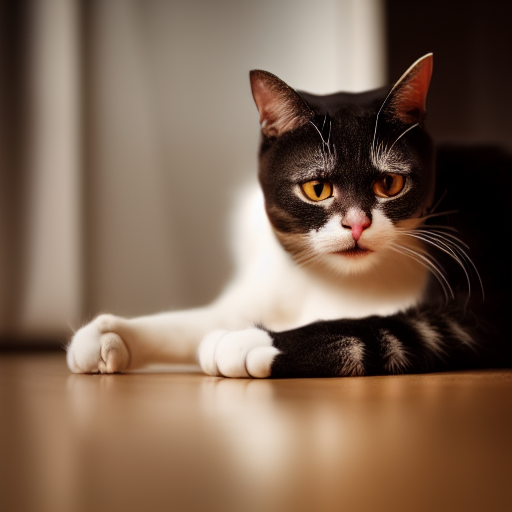

In [3]:
import model_loader
import pipeline
from PIL import Image
from pathlib import Path
from transformers import CLIPTokenizer
import torch

DEVICE = "cpu"

ALLOW_CUDA = True
ALLOW_MPS = False

if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"
elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:
    DEVICE = "mps"
print(f"Using device: {DEVICE}")

tokenizer = CLIPTokenizer("../data/vocab.json", merges_file="../data/merges.txt")
model_file = "../data/v1-5-pruned-emaonly.ckpt"
models = model_loader.preload_models_from_standard_weights(model_file, DEVICE)

## TEXT TO IMAGE

# prompt = "A dog with sunglasses, wearing comfy hat, looking at camera, highly detailed, ultra sharp, cinematic, 100mm lens, 8k resolution."
prompt = "A cat stretching on the floor, highly detailed, ultra sharp, cinematic, 100mm lens, 8k resolution."
uncond_prompt = ""  # Also known as negative prompt
do_cfg = True
cfg_scale = 8  # min: 1, max: 14

## IMAGE TO IMAGE

input_image = None
# Comment to disable image to image
image_path = "../images/cat.jpg"
# input_image = Image.open(image_path)
# Higher values means more noise will be added to the input image, so the result will further from the input image.
# Lower values means less noise is added to the input image, so output will be closer to the input image.
strength = 0.9

## SAMPLER

sampler = "ddpm"
num_inference_steps = 50
seed = 42

output_image = pipeline.generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    input_image=input_image,
    strength=strength,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    seed=seed,
    models=models,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
)

# Combine the input image and the output image into a single image.
Image.fromarray(output_image)

In [4]:
from ddpm import DDPMSampler

from PIL import Image
import torch
import numpy as np
import math

generator = torch.Generator()
generator.manual_seed(0)

ddpm_sampler = DDPMSampler(generator)

# How many noise levels to generate
noise_levels = [0, 10, 50, 75, 100, 250, 500, 750]

img = Image.open("../images/cat.jpg")
img_tensor = torch.tensor(np.array(img))
img_tensor = ((img_tensor / 255.0) * 2.0) - 1.0
# Create a batch by repeating the same image many times
batch = img_tensor.repeat(len(noise_levels), 1, 1, 1)

ts = torch.tensor(noise_levels, dtype=torch.int, device=batch.device)
noise_imgs = []
epsilons = torch.randn(batch.shape, device=batch.device)
# Generate a noisifed version of the image for each noise level
for i in range(len(ts)):
    a_hat = ddpm_sampler.alphas_cumprod[ts[i]]
    noise_imgs.append(
        (math.sqrt(a_hat) * batch[i]) + (math.sqrt(1 - a_hat) * epsilons[i])
    )


noise_imgs = torch.stack(noise_imgs, dim=0)
noise_imgs = (noise_imgs.clamp(-1, 1) + 1) / 2
noise_imgs = (noise_imgs * 255).type(torch.uint8)

# Convert back to image and display
display_img = Image.fromarray(noise_imgs[7].squeeze(0).numpy(), 'RGB')
display_img